In [1]:
from sklearn import metrics
import numpy as np
from classes.boosting_matrix import BoostingMatrix
from classes.dataset import Dataset
from settings import Settings
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from classes.pattern_boosting import PatternBoosting
from settings import Settings
from classes.enumeration.estimation_type import EstimationType
from data.synthetic_dataset import SyntheticDataset
import pandas as pd
import copy
import matplotlib.pyplot as plt
from classes.analysis import Analysis
from data.load_dataset import load_dataset
from data import data_reader
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from multiprocessing.dummy import Pool as ThreadPool
import functools
import copy
from data import data_reader
from jupiter_notebook_functions import *


Start by loading the model "pattern_boosting" and getting the frequency matrix

In [2]:
directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting")
frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                columns=pattern_boosting.boosting_matrix.get_header())

Frequency matrix:

In [2]:
tmp = frequency_matrix.sort_values(by=list(frequency_matrix.columns), ascending=False)
tmp.iloc[: 5, : 9]

NameError: name 'frequency_matrix' is not defined

Most common paths (counted by the total number of time they are present):

In [8]:
paths_total_presence = frequency_matrix.sum()
paths_total_presence.sort_values(ascending=False)[:5]

(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5)          6595.0
(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5)       6594.0
(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5)       6585.0
(44, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5)    6518.0
(44, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5)    6384.0
dtype: float64

Number of graph a path is present in

In [9]:
presence_per_observation = frequency_matrix.astype(bool).sum(axis=0)
presence_per_observation.sort_values(ascending=False)

(46,)                                                                                                                        554
(78,)                                                                                                                        429
(44,)                                                                                                                        413
(28,)                                                                                                                        384
(46, 7)                                                                                                                      368
                                                                                                                            ... 
(30, 7, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6)                                                                                          1
(30, 7, 7, 6, 7, 6, 7, 6, 7, 7, 6, 6)                                                            

Find paths up to length 'max_length' whose precessors are present in proportion p1,p2,p3, with boundaries "acceptable_error", note the ratio is made on the number of graphs a path is present, NOT the total number of times

In [ ]:
max_length = 4
proportions = [1, 0.5, 0.25, 0.125]
acceptable_error = 0.1



In [ ]:


finally_selected_paths = []

for index, value in presence_per_observation.items():
    ratios, founded_paths = get_ratio_with_next_paths(parent_index=index, parent_value=value,
                                                      presence_per_observation=presence_per_observation,
                                                      ratio=proportions[1], acccepred_error=acceptable_error)

    for i, path in enumerate(founded_paths):
        selected_ratios, selected_paths = get_ratio_with_next_paths(parent_index=path,
                                                                    parent_value=presence_per_observation[path],
                                                                    presence_per_observation=presence_per_observation,
                                                                    ratio=proportions[2],
                                                                    acccepred_error=acceptable_error)
        finally_selected_paths = copy.copy(finally_selected_paths + selected_paths)

finally_selected_paths

directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
data_reader.save_dataset_in_binary_file(dataset=finally_selected_paths, directory=directory,
                                        filename="finally_selected_paths", )

Paths that respect the first two ratios:

In [15]:
directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
finally_selected_paths = data_reader.load_data(directory=directory, filename="finally_selected_paths")

selected_paths = [item for item in finally_selected_paths if len(item) == 3]
selected_paths[:10]

[(57, 7, 7),
 (72, 7, 14),
 (78, 6, 7),
 (47, 7, 7),
 (74, 15, 8),
 (80, 7, 7),
 (77, 7, 7),
 (40, 7, 14),
 (21, 7, 14),
 (27, 6, 5)]

Now we generate the target paths, including the paths of length one and two

In [16]:
target_paths = []
for path in selected_paths:
    for i in range(len(path)):
        target_paths.append(path[:i])

Correlation matrices of subpaths

/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)
/Users/popcorn/PycharmProjects/pattern_boosting/venv/lib/python3.11/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from rag

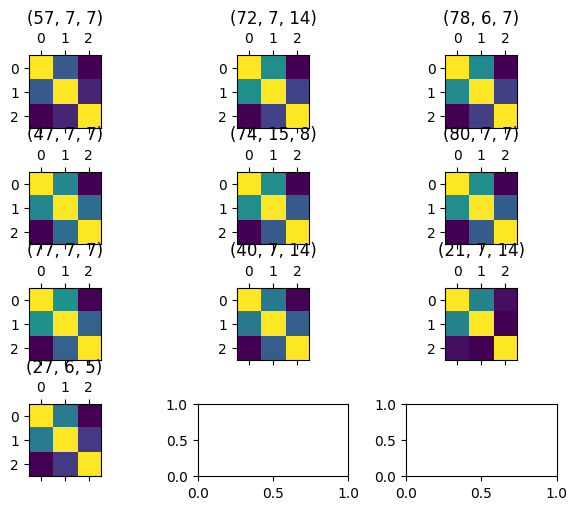

In [17]:


# number of plots per row
nppr = 3

number_of_plots = 10

nr_rows = ceildiv(len(selected_paths[:number_of_plots]), nppr)
fig, axs = plt.subplots(nr_rows, nppr)
fig.tight_layout()

for j, path in enumerate(selected_paths[:number_of_plots]):
    subpaths = []
    for i in range(1, len(path) + 1):
        subpaths.append(path[:i])
        column_number = j % nppr
        row_number = j // nppr
        axs[row_number, column_number].matshow(frequency_matrix[subpaths].corr())
        axs[row_number, column_number].set_title(str(path))

In [ ]:
nr_rows = ceildiv(len(selected_paths[number_of_plots:]), nppr)
fig, axs = plt.subplots(nr_rows, nppr)
fig.tight_layout()

for j, path in enumerate(selected_paths[number_of_plots:]):
    subpaths = []
    for i in range(1, len(path) + 1):
        subpaths.append(path[:i])
        column_number = j % nppr
        row_number = j // nppr
        axs[row_number, column_number].matshow(frequency_matrix[subpaths].corr())
        axs[row_number, column_number].set_title(str(path))

Correlation matrix over all the paths

In [ ]:
target_paths = list({(57, 7, 7), (57, 7), (57,),
                     (72, 7, 14), (72, 7), (72,),
                     (78, 6, 7), (78, 6), (78,),
                     (47, 7, 7), (47, 7), (47,),
                     (74, 15, 8), (74, 15), (74,),
                     (80, 7, 7), (80, 7), (80,),
                     (77, 7, 7), (77, 7), (77,),
                     (40, 7, 14), (40, 7), (40,),
                     (21, 7, 14), (21, 7), (21,),
                     (27, 6, 5), (27, 6), (27,),
                     (27, 6, 8),
                     (42, 7, 7), (42, 7), (42,),
                     (39, 7, 7), (39, 7), (39,),
                     (39, 7, 14),
                     (39, 6, 7), (39, 6),
                     (39, 6, 14),
                     (39, 6, 5),
                     (45, 7, 7), (45, 7), (45,),
                     (48, 8, 7), (48, 8), (48,)})
plt.matshow(frequency_matrix[target_paths].corr())


[22:29:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[22:29:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

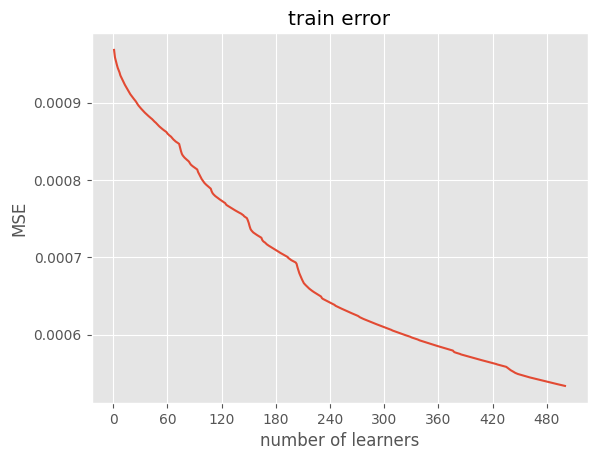

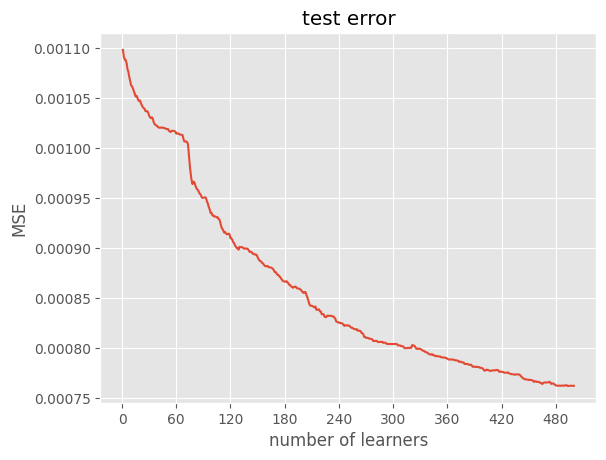

AttributeError: 'PatternBoosting' object has no attribute 'boosting_matrix_matrix_for_test_dataset'

In [5]:
analysis = Analysis()
directory = data_reader.get_save_location(folder_relative_path="results")
directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_500_max_path_length_100_5_k_selection_graphs'

analysis.load_and_analyze(directory=directory,
                          show=True,
                          save=False)

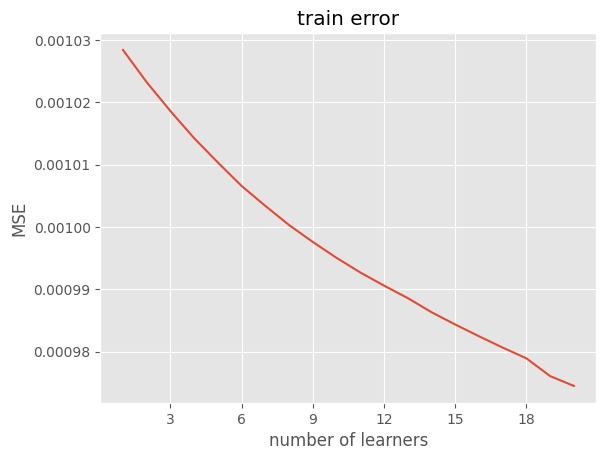

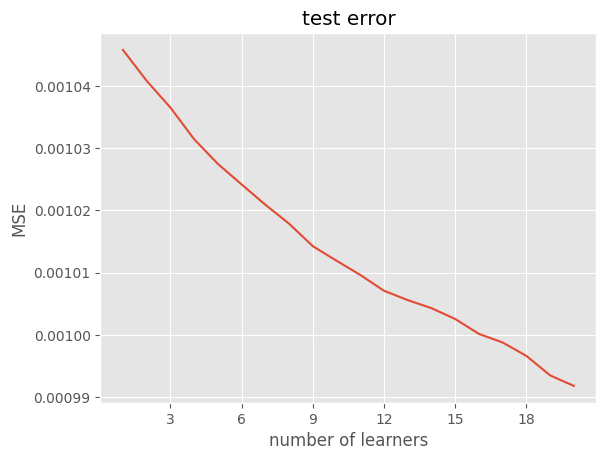

AttributeError: 'PatternBoosting' object has no attribute 'boosting_matrix_matrix_for_test_dataset'

In [3]:

analysis = Analysis()
directory = data_reader.get_save_location(folder_relative_path="results")
directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_20_max_path_length_100_60k_dataset'

analysis.load_and_analyze(directory=directory,

                          show=True,
                          save=True)

Here we run classic xgb ove the whole frequency matrix (the matrix is computed over the 5k selection dataset)

first load the matrix

In [2]:
directory = data_reader.get_save_location(folder_relative_path="results/jupiter", create_unique_subfolder=True)
pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting")

dataset = load_dataset("5_k_selection_graphs")



In [3]:
counter = 0
for i, path in enumerate(pattern_boosting.boosting_matrix.get_header()):
    if len(path) < 300:
        counter += 1
        if counter == 1:
            print(path)
        #print(path)
print(counter)
print(len(pattern_boosting.boosting_matrix.get_header()))
frequency_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                columns=pattern_boosting.boosting_matrix.get_header())


(57,)
98563
98563


Check that the matrix header is ordered by length

In [4]:
header = list(frequency_matrix.columns)
ordered = True
old_path = header[0]
for path in header:
    if len(old_path) > len(path):
        ordered = False
        break

ordered

True

In [49]:
max_number_of_learners = [1, 5, 10] + list(range(1, 300 + 1, 30))

max_path_length = [1, 2, 3, 4, 5, 15]



Setting up matrix readySetting up matrix ready
Setting up matrix ready
Frequency matrix ready
Setting up matrix ready

Frequency matrix ready
Frequency matrix ready
Frequency matrix ready
Setting up matrix ready
Setting up matrix ready
Frequency matrix ready
Frequency matrix ready
Learner number: Learner number:  1
 1
Learner number:  1
Learner number:  1
Learner number:  1
Learner number:  1
Learner number:  31
Learner number:  31
Learner number:  31
Learner number:  31
Learner number:  31
Learner number:  61
Learner number:  61
Learner number:  61
Learner number:  31
Learner number:  61
Learner number:  91
Learner number:  61
Learner number:  91
Learner number:  121
Learner number:  91
Learner number:  151
Learner number:  91
Learner number:  91
Learner number:  181
Learner number:  121
Learner number:  211
Learner number:  121
Learner number:  121
Learner number:  241
Learner number:  61
Learner number:  121
Learner number:  151
Learner number:  271
Learner number:  151
max path len

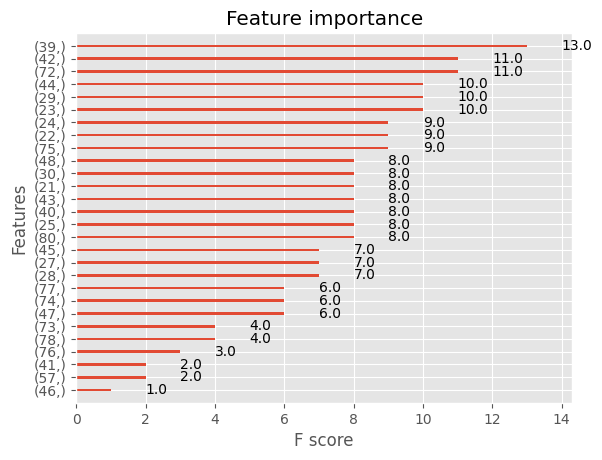

max path length:  1
Learner number:  151
Learner number:  181
Learner number:  151
Learner number:  181
Learner number:  181
Learner number:  211
Learner number:  91
Learner number:  181
Learner number:  211
Learner number:  211
Learner number:  241
Learner number:  211
Learner number:  241
Learner number:  241
Learner number:  271
Learner number:  121
Learner number:  241
Learner number:  271
max path length:  2
max path length:  2
Learner number:  271


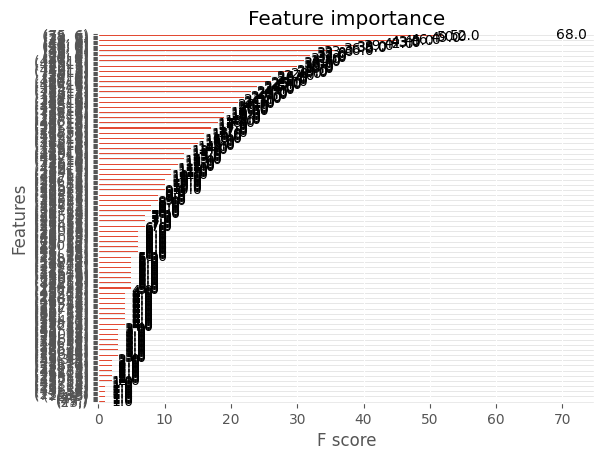

max path length:  2
Learner number:  271
max path length:  3
max path length:  3


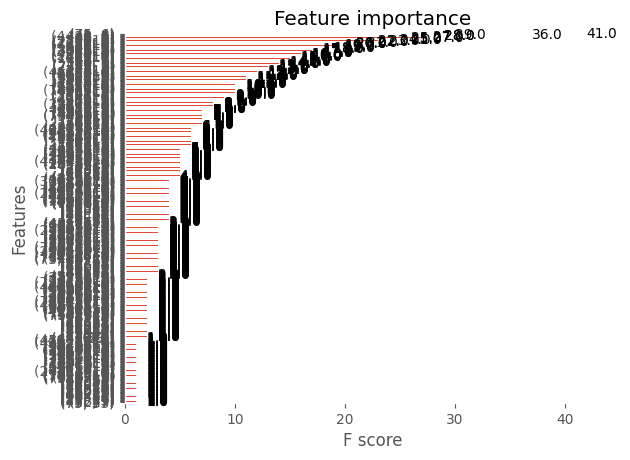

max path length:  3
max path length:  4
max path length:  4


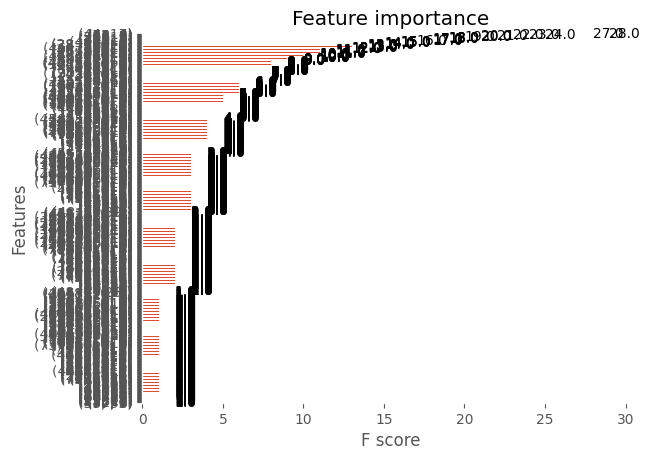

max path length:  4
Learner number:  151
max path length:  5
max path length:  5


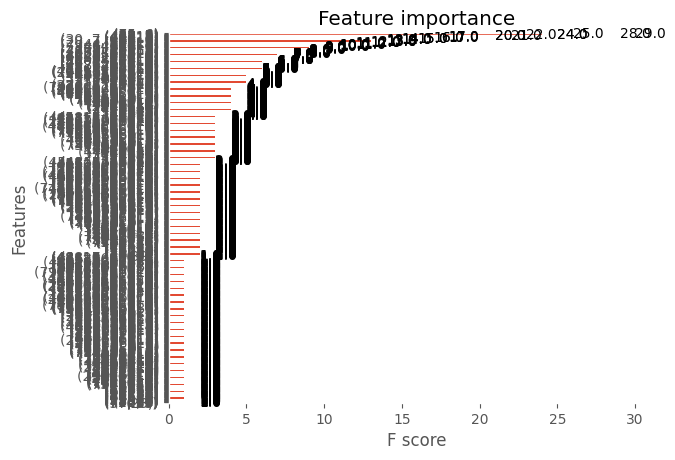

max path length:  5
Learner number:  181
Learner number:  211
Learner number:  241
Learner number:  271
max path length:  15
max path length:  15


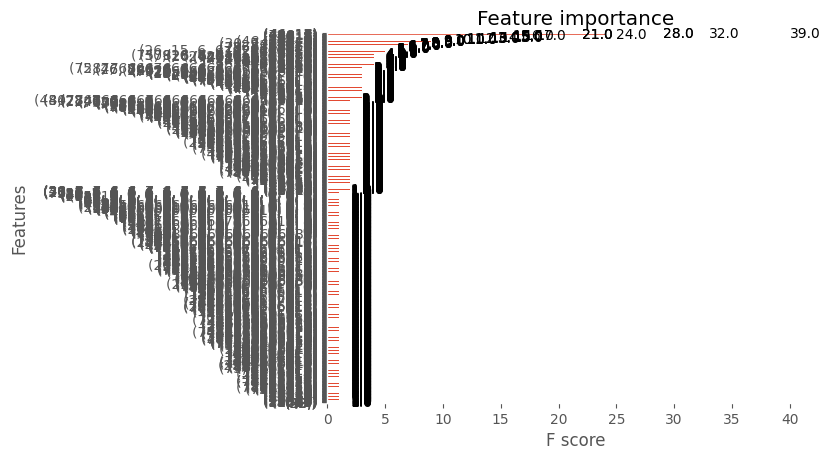

max path length:  15


In [50]:
pool = ThreadPool(min(10, len(max_path_length)))

xgb_err = pool.map(
    functools.partial(get_XGB_error_and_variable_importance,
                      frequency_matrix=copy.deepcopy(frequency_matrix),
                      labels=dataset.labels,
                      max_number_of_learners=max_number_of_learners),
    max_path_length)

xgb_test_err, xgb_train_err, variable_importance = zip(*xgb_err)





In [51]:
analysis = Analysis()
directory = data_reader.get_save_location(folder_relative_path="results")
directory = '/Users/popcorn/PycharmProjects/pattern_boosting/results/Xgb_step_500_max_path_length_100_5_k_selection_graphs'

pattern_boosting = data_reader.load_data(directory=directory, filename="pattern_boosting")


[09:45:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[09:45:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

15
Setting up matrix ready
Frequency matrix ready
Learner number:  1
Learner number:  31
Learner number:  61
Learner number:  91
Learner number:  121
Learner number:  151
Learner number:  181
Learner number:  211
Learner number:  241
Learner number:  271
max path length:  15
max path length:  15


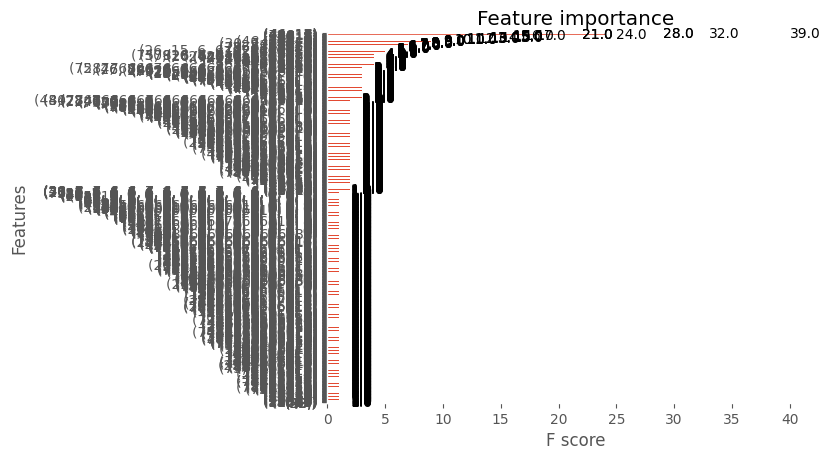

max path length:  15


In [52]:
# Run xgb full power and on the frequency matrix given by pattern boosting

xgb_settings = Settings.xgb_model_parameters
xgb_settings['max_depth'] = 5
print(max_path_length[-1])
test_err_full_power_xgb, train_err_full_power_xgb, _ = get_XGB_error_and_variable_importance(
    max_path_length=max_path_length[-1],
    frequency_matrix=copy.deepcopy(frequency_matrix),
    labels=dataset.labels,
    max_number_of_learners=max_number_of_learners,
    xgb_settings=xgb_settings)



Setting up matrix ready
Frequency matrix ready
Learner number:  1
Learner number:  31
Learner number:  61
Learner number:  91
Learner number:  121
Learner number:  151
Learner number:  181
Learner number:  211
Learner number:  241
Learner number:  271
max path length:  15
max path length:  15


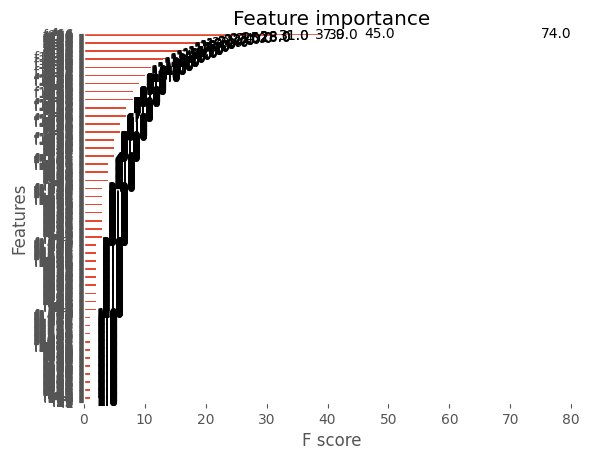

max path length:  15


In [55]:
from jupiter_notebook_functions import *

pd_pattern_boosting_matrix = pd.DataFrame(pattern_boosting.boosting_matrix.get_matrix(),
                                          columns=pattern_boosting.boosting_matrix.get_header())


#different split for train and test data
def get_XGB_error_and_variable_importance_t(max_path_length, pattern_boosting, max_number_of_learners,
                                            xgb_settings=None):
    header = list(frequency_matrix.columns)

    columns_to_be_removed = []
    print("Setting up matrix ready")
    for i, path in enumerate(header):
        if len(path) > max_path_length:
            columns_to_be_removed.append(path)
    print("Frequency matrix ready")
    x_test = pattern_boosting.create_boosting_matrix_for(pattern_boosting.test_dataset)
    x_train = pattern_boosting.boosting_matrix.matrix
    y_test = pattern_boosting.test_dataset.labels
    y_train = pattern_boosting.training_dataset.labels

    if xgb_settings is None:
        xgb_settings = Settings.xgb_model_parameters
    if isinstance(max_number_of_learners, Iterable):
        learners_numbers = max_number_of_learners
    else:
        learners_numbers = list(range(1, max_number_of_learners, 1))
    xgb_test_err = []
    xgb_train_err = []
    features_importance = None
    #for i in range(1, max_number_of_learners + 1,10):

    if isinstance(max_number_of_learners, Iterable):
        learners_numbers = max_number_of_learners
    for i in learners_numbers:
        print("Learner number: ", i)
        #create xgb model
        #print("number of base learners: ", i)
        xgb_settings['n_estimators'] = i - 1
        xgb_model = XGBRegressor(**xgb_settings)

        xgb_model.fit(x_train, y_train)

        # test the model
        y_test_pred = xgb_model.predict(x_test)
        y_train_pred = xgb_model.predict(x_train)

        if Settings.final_evaluation_error == "MSE":
            model_test_error = metrics.mean_squared_error(y_test, y_test_pred)
            model_train_error = metrics.mean_squared_error(y_train, y_train_pred)
        elif Settings.final_evaluation_error == "absolute_mean_error":
            model_test_error = metrics.mean_absolute_error(y_test, y_test_pred)
            model_train_error = metrics.mean_absolute_error(y_train, y_train_pred)
        else:
            raise ValueError("measure error not found")
        xgb_test_err.append(model_test_error)
        xgb_train_err.append(model_train_error)
        features_importance = xgb_model.feature_importances_

    # plot feature importance
    print("max path length: ", max_path_length)
    plot_importance(xgb_model)
    print("max path length: ", max_path_length)
    plt.show()
    print("max path length: ", max_path_length)
    xgb_test_err = np.array(xgb_test_err)
    return xgb_test_err, xgb_train_err, features_importance


test_err_full_power_xgb_on_pattern_boosting_matrix, train_err_full_power_xgb_on_pattern_boosting_matrix, _ = get_XGB_error_and_variable_importance_t(
    max_path_length=max_path_length[-1],
    pattern_boosting=pattern_boosting,
    max_number_of_learners=max_number_of_learners,
    xgb_settings=xgb_settings)


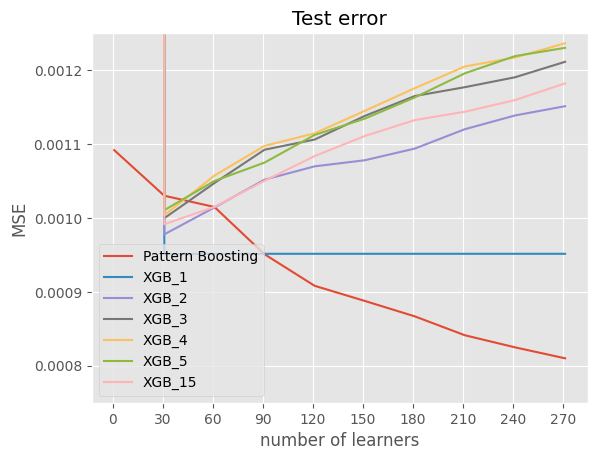

In [56]:
list(max_number_of_learners)
fig, ax = plot_graphs_new(x=max_number_of_learners,
                          y=np.array(pattern_boosting.test_error)[list(max_number_of_learners)],
                          tittle="Test error", x_label="number of learners",
                          y_label="MSE", show=True, save=False, y2=xgb_test_err, x2=None,
                          max_path_length=max_path_length)



In [57]:
#add full power xgb error and xgb on pattern boosting matrix error to the plot

ax.plot(max_number_of_learners, test_err_full_power_xgb, label='XGB depth ' + str(xgb_settings['max_depth']))
ax.plot(max_number_of_learners, test_err_full_power_xgb_on_pattern_boosting_matrix, label="XGB on pb matrix")

plt.show()

Use pattern boosting matrix
check training error


In [58]:
def plot_graphs_new_temp(x, y, tittle: str, x_label: str = "", y_label: str = "", show=True, save=True, y2=None,
                         x2=None,
                         max_path_length=[]):
    plt.style.use('ggplot')
    if x2 == None:
        x2 = x
    fig, ax = plt.subplots()
    ax.set_ylim(0.00, 0.0025)
    # Using set_dashes() to modify dashing of an existing line
    if len(x) > Settings.tail:
        ax.plot(x[-Settings.tail:], y[-Settings.tail:], label='')
    else:
        ax.plot(x, y, label='Pattern Boosting')
        for i, max_length in enumerate(max_path_length):
            ax.plot(x2, y2[i], label='XGB_' + str(max_length))

    ax.plot(max_number_of_learners, test_err_full_power_xgb, label='XGB depth ' + str(xgb_settings['max_depth']))
    ax.plot(max_number_of_learners, test_err_full_power_xgb_on_pattern_boosting_matrix, label="XGB on pb matrix")

    # plt.grid()
    ax.legend()
    ax.set_title(tittle)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    # plot only integers on the x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    saving_location = data_reader.get_save_location(tittle, '.png')

    if save is True:
        plt.savefig(saving_location)
    if show is True:
        plt.show()

    return fig, ax


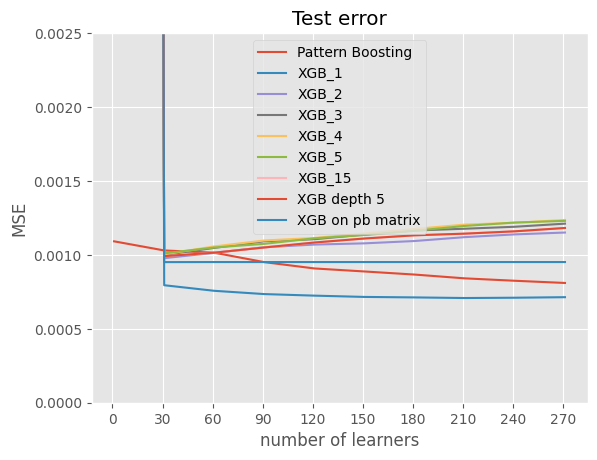

In [59]:
fig, ax = plot_graphs_new_temp(x=max_number_of_learners,
                               y=np.array(pattern_boosting.test_error)[max_number_of_learners],
                               tittle="Test error", x_label="number of learners",
                               y_label="MSE", show=True, save=False, y2=xgb_test_err, x2=None,
                               max_path_length=max_path_length)

In [60]:
def plot_graphs_new_temp_2(x, y, tittle: str, x_label: str = "", y_label: str = "", show=True, save=True, y2=None,
                           x2=None,
                           max_path_length=[]):
    plt.style.use('ggplot')
    if x2 == None:
        x2 = x
    fig, ax = plt.subplots()
    ax.set_ylim(0.00065, 0.00125)
    # Using set_dashes() to modify dashing of an existing line
    if len(x) > Settings.tail:
        ax.plot(x[-Settings.tail:], y[-Settings.tail:], label='')
    else:
        ax.plot(x, y, label='Pattern Boosting')
        for i, max_length in enumerate(max_path_length):
            ax.plot(x2, y2[i], label='XGB_' + str(max_length))

    ax.plot(max_number_of_learners, train_err_full_power_xgb, label='XGB depth ' + str(xgb_settings['max_depth']))
    ax.plot(max_number_of_learners, train_err_full_power_xgb_on_pattern_boosting_matrix, label="XGB on pb matrix")

    # plt.grid()
    ax.legend()
    ax.set_title(tittle)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    # plot only integers on the x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    saving_location = data_reader.get_save_location(tittle, '.png')

    if save is True:
        plt.savefig(saving_location)
    if show is True:
        plt.show()

    return fig, ax

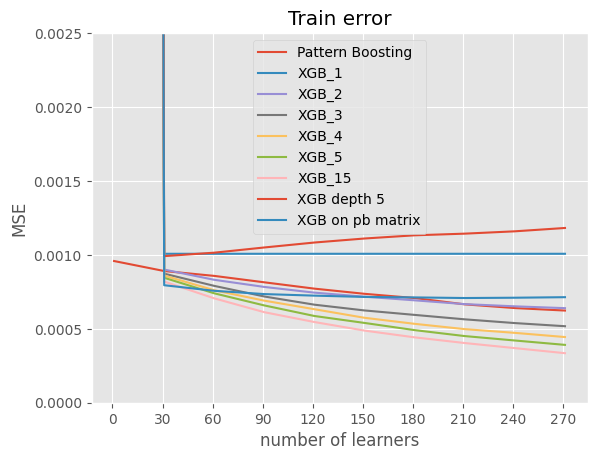

In [61]:
fig, ax = plot_graphs_new_temp(x=max_number_of_learners,
                               y=np.array(pattern_boosting.train_error)[max_number_of_learners],
                               tittle="Train error", x_label="number of learners",
                               y_label="MSE", show=True, save=False, y2=xgb_train_err, x2=None,
                               max_path_length=max_path_length)